# 1. Introduction
This notebook contains the code for the GIS section of the project. It extracts the necessary building data from the shapefiles and creates the necessary parameter DataFrames for the cooling demand model (CDM).


## 1.1 Prepare environment

### Import libraries

In [30]:
import re
from pathlib import Path

import geopandas as gpd
import matplotlib.colors as plt_colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
from itables import init_notebook_mode
from rasterstats import zonal_stats
from scipy.stats import spearmanr

from functions.geometric import azimuth_rectangle

# To improve interaction with DataFrames
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

### Define global parameters


In [2]:
ENERGY_LABEL_TO_INT = {  # Dictionary to translate the energy labels to a integer value
    "A+++++": 1,
    "A++++": 2,
    "A+++": 3,
    "A++": 4,
    "A+": 5,
    "A": 6,
    "B": 7,
    "C": 8,
    "D": 9,
    "E": 10,
    "F": 11,
    "G": 12,
}

ENERGY_CLASS_TO_INT = {
    "A-A+++++": 1,
    "B-C": 2,
    "D-E": 3,
    "F-G": 4,
}

# 2. Pre-processing GIS data

## 2.1 Residence level data

### Load data

#### Define path and layers names

In [ ]:
ENERGY_LABELS_PATH = Path("data/input/geodata/energy_labels_TheHague.csv")
POSTCODES_PATH = Path("data/input/geodata/postcodes_TheHague.csv")
BAG_RESIDENCES_INPUT_PATH = Path("data/input/geodata/BAG_residences_TheHague.gpkg")
BAG_RESIDENCES_LAYER_NAME = "BAG_residences"
BAG_RESIDENCES_OUTPUT_PATH = Path("data/output/geodata/BAG_residences_with_e_labels.gpkg")

#### Read in data

In [ ]:
# Read the energy labels csv file
e_labels = pd.read_csv(ENERGY_LABELS_PATH, sep=";", dtype="str", low_memory=False)

# Extract the list of postcodes in The Hague
postcodes_TheHague = pd.read_csv(POSTCODES_PATH, sep=",", dtype="str")

# Open GeoPackage with BAG residences using geopandas
bag_residences = gpd.read_file(BAG_RESIDENCES_INPUT_PATH, layer=BAG_RESIDENCES_LAYER_NAME)

#### Pre-process BAG residence data

In [ ]:
# Rename columns of BAG residences DataFrame
column_translation_BAG_residences = {  # Dictionary to translate column names from BAG (Dutch) to Python model (English)
    "feature_id": "feature_id",  # ID of feature in the GIS model
    "identificatie": "id_BAG",  # ID of residence in BAG database
    "oppervlakte": "floor_area_m2",  # Floor area of residence in square meters
    "status": "status",  # Status of residence (in use, demolished, not built yet)
    "gebruiksdoel": "end_use",  # End use of residence (residential, office, etc.)
    "geometry": "geometry",  # Geometry data of residence (used in GIS)
}

# Translate columns from BAG (Dutch) to Python model (English)
bag_residences = bag_residences.rename(columns=column_translation_BAG_residences)

# Keep only columns with data used in the model
bag_residences = bag_residences[list(column_translation_BAG_residences.values())]

### Join data

#### Extract the The Hague energy labels from the National dataset

In [ ]:
# Extract the first 4 digits of the postcode in the energy labels dataset
e_labels["postcode_numerical"] = e_labels["Postcode"].str[:4]

# Filter the energy labels dataset to only include postcodes in The Hague
e_labels_TheHague = e_labels[e_labels["postcode_numerical"].isin(postcodes_TheHague["postcode"].tolist())]

# Add a column to the energy labels dataset translating the energy labels to an integer value
e_labels_TheHague["energy_label_int"] = e_labels_TheHague["Energieklasse"].replace(ENERGY_LABEL_TO_INT)

# Drop the rows with NaN values in the BAGverblijfsobjectid column
e_labels_TheHague = e_labels_TheHague.dropna(subset=["BAGverblijfsobjectid"])

#### Join energy labels to BAG residences

In [ ]:
# Join the energy_label_numerical column of the e_labels_TheHague dataset to the bag_residences dataset
bag_residences = bag_residences.merge(
    e_labels_TheHague[["BAGverblijfsobjectid", "energy_label_int"]],
    left_on="id_BAG",
    right_on="BAGverblijfsobjectid",
    how="left",
)

# Drop BAGverblijfsobjectid column
bag_residences = bag_residences.drop(columns=["BAGverblijfsobjectid"])

### Save data

In [ ]:
# Save the bag_residences DataFrame to a GeoPackage file
bag_residences.to_file(BAG_RESIDENCES_OUTPUT_PATH, layer=BAG_RESIDENCES_LAYER_NAME, driver="GPKG")

## 2.2 Building level data

### Load data

#### Define path and layers names

In [ ]:
BAG_BUILDINGS_INPUT_PATH = Path("data/input/geodata/BAG_buildings_TheHague.gpkg")
BAG_BUILDINGS_MAIN_LAYER_NAME = "BAG_buildings"
BAG_3D_ROOF_ELEVATIONS_LAYER_NAME = "BAG_3D_roof_elevations"
BAG_3D_GROUND_ELEVATIONS_LAYER_NAME = "BAG_3D_ground_elevations"
BAG_BUILDINGS_OUTPUT_PATH = Path("data/output/geodata/BAG_buildings_with_height_data.gpkg")
BAG_MPRS_LAYER_NAME = "BAG_building_MPRs"

#### Read in data

In [ ]:
# Open GeoPackages with BAG building-level layers using geopandas
bag_buildings = gpd.read_file(
    BAG_BUILDINGS_INPUT_PATH,
    layer=BAG_BUILDINGS_MAIN_LAYER_NAME,
)  # Main layer with building data
bag_3d_roof_elevations = gpd.read_file(
    BAG_BUILDINGS_INPUT_PATH,
    layer=BAG_3D_ROOF_ELEVATIONS_LAYER_NAME,
)  # Layer with roof heights in meters
bag_3d_ground_elevations = gpd.read_file(
    BAG_BUILDINGS_INPUT_PATH,
    layer=BAG_3D_GROUND_ELEVATIONS_LAYER_NAME,
)  # Layer with ground elevations in meters

#### Pre-process the main BAG Buildings layer

In [ ]:
# Rename columns of BAG buildings DataFrame
column_translation_BAG_buildings = {  # Dictionary to translate column names from BAG (Dutch) to Python model (English)
    "feature_id": "feature_id",  # ID of feature in the GIS model
    "identificatie": "id_BAG",  # ID of residence in BAG database
    "bouwjaar": "construction_year",  # Year of building construction
    "status": "status",  # Status of building (in use, demolished, not built yet)
    "geometry": "geometry",  # Geometry data of building (used in GIS)
}

# Translate column names from BAG (Dutch) to Python model (English)
bag_buildings = bag_buildings.rename(columns=column_translation_BAG_buildings)

# Keep only columns with data used in the model
bag_buildings = bag_buildings[list(column_translation_BAG_buildings.values())]

# Calculate surface of the ground floor, which is assumed to follow the shape of the building,  in square meters
bag_buildings["floor_area_ground_m2"] = bag_buildings["geometry"].area

### Join data

#### Join height data to main buildings layer


In [ ]:
# Extract BAG ID for both bag_3d_roof_elevations and bag_3d_ground_elevations using str.split(".").str[-1]
bag_3d_roof_elevations["BAG_building_ID"] = bag_3d_roof_elevations["identificatie"].str.split(".").str[-1]
bag_3d_ground_elevations["BAG_building_ID"] = bag_3d_ground_elevations["identificatie"].str.split(".").str[-1]

# Join the 70th percentile of roof elevation from bag_3d_roof_elevations to bag_buildings
bag_buildings = bag_buildings.merge(
    bag_3d_roof_elevations[["BAG_building_ID", "b3_h_70p"]],
    left_on="id_BAG",
    right_on="BAG_building_ID",
    how="left",
)

# Drop BAG_building_ID column from joined DataFrame
bag_buildings = bag_buildings.drop(columns=["BAG_building_ID"])

# Join ground elevation from bag_3d_ground_elevations to bag_buildings
bag_buildings = bag_buildings.merge(
    bag_3d_ground_elevations[["BAG_building_ID", "b3_h_maaiveld"]],
    left_on="id_BAG",
    right_on="BAG_building_ID",
    how="left",
)

# Drop BAG_building_ID column from joined DataFrame
bag_buildings = bag_buildings.drop(columns=["BAG_building_ID"])

# Rename height columns from 3D BAG
bag_buildings = bag_buildings.rename(columns={"b3_h_70p": "roof_elevation_m", "b3_h_maaiveld": "ground_elevation_m"})

# Calculate height of building in meters from BAG 3D data
bag_buildings["height_m"] = bag_buildings["roof_elevation_m"] - bag_buildings["ground_elevation_m"]

# Drop duplicate rows
bag_buildings = bag_buildings.drop_duplicates()

# Drop buildings with no height data (<1% of the total floor area)
bag_buildings = bag_buildings.dropna(subset=["height_m"])

#### Calculate building volumes

In [ ]:
# Calculate the volume of the building in m3 by multiplying the ground floor area with the height of the building
bag_buildings["volume_m3"] = bag_buildings["height_m"] * bag_buildings["floor_area_ground_m2"]

#### Determine minimum bounding rectangles (MBRs)

In [ ]:
# Determine the minimum bounding rectangle (MBR) of the buildings
bag_buildings["MBR_geometry"] = bag_buildings.geometry.apply(lambda geom: geom.minimum_rotated_rectangle)

# Calculate azimuth, i.e. orientation angle of the MBRs, and the width and length of the MBRs in meters
(
    bag_buildings["MBR_azimuth"],
    bag_buildings["MBR_width_m"],
    bag_buildings["MBR_length_m"],
) = zip(*bag_buildings["MBR_geometry"].map(azimuth_rectangle), strict=True)

#### Create a new layer to save the MBR geometries for visualisation purposes

In [ ]:
# Create a new DataFrame with only the MBR data
bag_buildings_MBR = bag_buildings[["id_BAG", "MBR_geometry", "MBR_azimuth", "MBR_width_m", "MBR_length_m"]]

# Rename MBR_geometry to geometry
bag_buildings_MBR = bag_buildings_MBR.rename(columns={"MBR_geometry": "geometry"})

# Drop MBR_geometry in main DataFrame as a layer can only have one geometry column
bag_buildings = bag_buildings.drop(columns=["MBR_geometry"])

### Save data

In [ ]:
# Write GeoDataFrames to GeoPackage
bag_buildings.to_file(BAG_BUILDINGS_OUTPUT_PATH, layer=BAG_BUILDINGS_MAIN_LAYER_NAME, driver="GPKG")
bag_buildings_MBR.to_file(BAG_BUILDINGS_OUTPUT_PATH, layer=BAG_MPRS_LAYER_NAME, driver="GPKG")

## 2.3 Joining residence-level data to building-level data

#### Define constants for the section


In [ ]:
# Define path and layer names
BAG_BUILDINGS_WITH_HEIGHT_DATA_INPUT_PATH = Path("data/output/geodata/BAG_buildings_with_height_data.gpkg")
BAG_BUILDINGS_WITH_HEIGHT_DATA_LAYER_NAME = "BAG_buildings"
BAG_RESIDENCES_WITH_E_LABELS_INPUT_PATH = Path("data/output/geodata/BAG_residences_with_e_labels.gpkg")
BAG_RESIDENCES_WITH_E_LABELS_LAYER_NAME = "BAG_residences"
BAG_BUILDINGS_WITH_RESIDENCE_DATA_OUTPUT_PATH = Path("data/output/geodata/BAG_buildings_with_residence_data.gpkg")
BAG_BUILDINGS_WITH_RESIDENCE_DATA_LAYER_NAME = "BAG_buildings"

# Set to True to work with a subset of the data, False to work with all data
WORK_WITH_SUBSET = True

# Rename path and layers names accordingly
if WORK_WITH_SUBSET:
    BAG_BUILDINGS_WITH_RESIDENCE_DATA_LAYER_NAME = BAG_BUILDINGS_WITH_RESIDENCE_DATA_LAYER_NAME + "_subset"
    BAG_BUILDINGS_WITH_RESIDENCE_DATA_OUTPUT_PATH = re.sub(r"(\.gpkg)$", r"_subset\1", str(BAG_BUILDINGS_WITH_RESIDENCE_DATA_OUTPUT_PATH))

#### Read in data
If needed, read the residence and building data from the GeoPackages

In [ ]:
# Read the BAG buildings and residences layers
bag_buildings = gpd.read_file(filename=BAG_BUILDINGS_WITH_HEIGHT_DATA_INPUT_PATH, layer=BAG_BUILDINGS_WITH_HEIGHT_DATA_LAYER_NAME)
bag_residences = gpd.read_file(filename=BAG_RESIDENCES_WITH_E_LABELS_INPUT_PATH, layer=BAG_RESIDENCES_WITH_E_LABELS_LAYER_NAME)

### Create a subset of the BAG for easier plotting and troubleshooting

In [ ]:
bbox = bag_buildings.total_bounds  # Find bounding box of the buildings DataFrame

bbox_width = bbox[2] - bbox[0]  # Calculate width of bounding box
bbox_length = bbox[3] - bbox[1]  # Calculate length of bounding box

# Create a new bounding box that is a fraction of the size of the original bounding box
size_down_ratio = 0.1
x_shift = 0.5
y_shift = 0.65

bbox_small = [
    bbox[0] + bbox_width * x_shift,
    bbox[1] + bbox_length * y_shift,
    bbox[2] - bbox_width * (1 - x_shift + size_down_ratio),
    bbox[3] - bbox_length * (1 - y_shift + size_down_ratio),
]

# Take selection of buildings and residences in a bounding box around the city center and plot it
bag_buildings_subset = bag_buildings.cx[bbox_small[0] : bbox_small[2], bbox_small[1] : bbox_small[3]]
bag_residences_subset = bag_residences.cx[bbox_small[0] : bbox_small[2], bbox_small[1] : bbox_small[3]]
# Plot the selections
ax = bag_buildings_subset.plot(color="lightgreen")
bag_residences_subset.plot(ax=ax, color="grey", markersize=0.5)
print(f"Size of selection: {len(bag_buildings_subset)} buildings and {len(bag_residences_subset)} residences")

### Perform joins


In [ ]:
if WORK_WITH_SUBSET:
    bag_residences = bag_residences_subset
    bag_buildings = bag_buildings_subset

else:
    bag_residences_subset = None
    bag_buildings_subset = None

#### Generate joined GeoDataFrame to perform aggregations with

In [ ]:
# Join the buildings and residences GeoDataFrames
joined_gdf = gpd.sjoin(bag_residences, bag_buildings, predicate="within")

# Convert the energy labels to floats for calculations
joined_gdf["energy_label_int"] = joined_gdf["energy_label_int"].astype("float")

#### Determine the mean energy label per building, weighed by the floor area

In [ ]:
# Calculate the mean energy label per building, weighted by floor area of the residences, but not including nan energy labels in the averaging
mean_energy_label_per_building = (
    joined_gdf.dropna(subset="energy_label_int").groupby("index_right").apply(lambda x: round(np.average(x["energy_label_int"], weights=x["floor_area_m2"]))).reset_index()
)

# Rename columns and reset index for merging back to buildings DataFrame
mean_energy_label_per_building = mean_energy_label_per_building.rename(columns={0: "energy_label_int"})
mean_energy_label_per_building = mean_energy_label_per_building.set_index("index_right")

# Join the mean energy label per building to the buildings DataFrame
bag_buildings = bag_buildings.merge(mean_energy_label_per_building, left_index=True, right_index=True, how="left")

# Convert the energy labels back to text: 1: A+++++, 2: A++++, etc.
int_to_energy_label = {v: k for k, v in ENERGY_LABEL_TO_INT.items()}
bag_buildings["energy_label"] = bag_buildings["energy_label_int"].replace(int_to_energy_label)

#### Determine the main end use per building by the floor area

In [ ]:
# Calculate the floor area per end use per building
floor_area_per_end_use_per_building = joined_gdf.groupby(["index_right", "end_use"])["floor_area_m2"].sum().reset_index()

# Select the end use with the largest floor area per building
end_use_per_building = floor_area_per_end_use_per_building.loc[floor_area_per_end_use_per_building.groupby("index_right")["floor_area_m2"].idxmax()]

# Reset index for merging back to buildings DataFrame
end_use_per_building = end_use_per_building.set_index("index_right")

# Join the main end use per building to the buildings DataFrame
bag_buildings = bag_buildings.merge(end_use_per_building["end_use"], left_index=True, right_index=True, how="left")

#### Determine total floor area and amount of residences per building

In [ ]:
aggregations = {
    "floor_area_m2": sum,  # Sum floor area of residences
    "id_BAG_left": pd.Series.nunique,  # Count number of unique residences
}

# Perform aggregation using the groupby and agg functions and ignore nan values, but keep all columns of the buildings DataFrame
floor_area_and_residence_count_per_building = joined_gdf.groupby("index_right").agg(aggregations).reset_index()

# Rename columns adn reset index for merging back to buildings DataFrame
floor_area_and_residence_count_per_building = floor_area_and_residence_count_per_building.rename(
    columns={"floor_area_m2": "floor_area_total_m2", "id_BAG_left": "number_of_residences"},
)
floor_area_and_residence_count_per_building = floor_area_and_residence_count_per_building.set_index("index_right")

# Join the total floor area and residence count per building to the buildings DataFrame
bag_buildings = bag_buildings.merge(floor_area_and_residence_count_per_building, left_index=True, right_index=True, how="left")

### Save data

In [ ]:
# Write building GeoDataFrame with residence data to GeoPackage
bag_buildings.to_file(BAG_BUILDINGS_WITH_RESIDENCE_DATA_OUTPUT_PATH, layer=BAG_BUILDINGS_WITH_RESIDENCE_DATA_LAYER_NAME, driver="GPKG")

## 2.4 Bonus: Analyzing relationship between economic status and UHI effect

### Load data

#### Define path and layers names

In [25]:
UHI_raster_image_path = Path("data/input/geodata/UHI_effect_TheHague.tif")
geographic_divisions_path = Path("data/input/geodata/GeographicDivisions_TheHague.gpkg")
census_blocks_layer = "Census_blocks_100m_TheHague_2019"  # Income data is only available up to 2019
outline_layer = "Outline_TheHague"

#### Read in data

In [ ]:
uhi_raster = rasterio.open(UHI_raster_image_path)  # UHI raster image
census_blocks = gpd.read_file(geographic_divisions_path, layer=census_blocks_layer)  # Census blocks
outline_TH = gpd.read_file(filename=geographic_divisions_path, layer=outline_layer)  # The outline of The Hague

#### Pre-process data

In [ ]:
uhi_data = uhi_raster.read(1)  # Read the first band of the raster image
uhi_data[uhi_data == -9999] = np.nan  # Replace -9999 values with NaN for easier plotting and calculations
plt.imshow(uhi_data, cmap="RdYlBu_r")  # Plot the raster image

In [84]:
# CBS denotes missing values as -99997, these are replaced with NaN for easier plotting and calculations
census_blocks = census_blocks.replace(-99997, np.nan)

# The column containing the mean house value is translated
census_blocks.rename(columns={"gemiddeldeWozWaardeWoning": "house_value_mean_1000_eur"}, inplace=True)

# Create a mapping dictionary for the conversion of the median income column to a numerical value
income_text_to_number = {
    "00-20 laag": 10,
    "00-40 laag tot onder midden": 20,
    "20-40 onder midden": 30,
    "20-60 onder midden tot midden": 40,
    "40-60 midden": 50,
    "40-80 midden tot boven midden": 60,
    "60-80 boven midden": 70,
    "60-100 boven midden tot hoog": 80,
    "80-100 hoog": 90,
    "onclassificeerbaar": None,
}

# Use the map function to convert the values in the column
census_blocks["household_income_median_1000_eur"] = census_blocks["mediaanInkomenHuishouden"].map(income_text_to_number)

#### Join UHI effect to census blocks

In [38]:
# Calculate mean UHI effect within each census block, in degrees Celsius
stats = zonal_stats(census_blocks, uhi_data, affine=uhi_raster.transform, nodata=np.nan, stats="mean")

# Add mean UHI effect to census blocks GeoDataFrame
census_blocks["UHI_effect_mean_C"] = [stat["mean"] if stat is not None else None for stat in stats]

#### Plot the maps

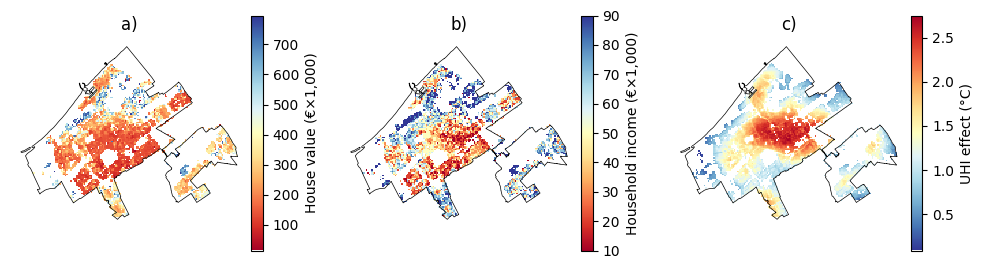

In [205]:
# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Define parameters for the colorbar appearance
legend_kwds = [
    {
        "label": "House value (€×1,000)",
        "pad": 0.01,
        "shrink": 0.5,
    },
    {
        "label": "Household income (€×1,000)",
        "pad": 0.01,
        "shrink": 0.5,
    },
    {
        "label": "UHI effect (°C)",
        "pad": 0.01,
        "shrink": 0.5,
    },
]

# Plot the mean house value (cutoff at 800,000 euros to prevent outliers from dominating the color scale)
census_blocks[census_blocks["house_value_mean_1000_eur"] < 800].plot(column="house_value_mean_1000_eur", cmap="RdYlBu", legend=True, ax=axes[0], legend_kwds=legend_kwds[0])
axes[0].set_title("a)")

# Plot the median household income
census_blocks.plot(column="household_income_median_1000_eur", cmap="RdYlBu", legend=True, ax=axes[1], legend_kwds=legend_kwds[1])
axes[1].set_title("b)")

# Plot the mean UHI effect
census_blocks.plot(column="UHI_effect_mean_C", cmap="RdYlBu_r", legend=True, ax=axes[2], legend_kwds=legend_kwds[2])
axes[2].set_title("c)")

for ax in axes:
    ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
    ax.set_axis_off()  # Remove the axis labels

plt.tight_layout()
plt.savefig(f"data/output/images/GIS/economic_status_vs_UHI_census_blocks_100m.png", dpi=300, bbox_inches="tight")
plt.show()

#### Determine correlation between economic status and UHI effect

In [129]:
# Create subset of census blocks with UHI effect, household income and house value data that is not NaN
census_blocks_subset = census_blocks.dropna(subset=["UHI_effect_mean_C", "household_income_median_1000_eur", "house_value_mean_1000_eur"])

In [206]:
# Determine spearman correlation coefficients between the mean UHI effect and the mean house value
corr_house_value, p_value_house_value = spearmanr(census_blocks_subset["UHI_effect_mean_C"], census_blocks_subset["house_value_mean_1000_eur"])
print(f"Correlation coefficient for mean UHI effect vs. mean house value: {corr_house_value:.2f}")
print(f"p value for mean UHI effect vs. mean house value: {p_value_house_value:.2e}")

# Determine spearman correlation coefficients between the mean UHI effect and the median household income
corr_income, p_value_income = spearmanr(census_blocks_subset["UHI_effect_mean_C"], census_blocks_subset["household_income_median_1000_eur"])
print(f"Correlation coefficient for mean UHI effect vs. median household income: {corr_income:.2f}")
print(f"p value for mean UHI effect vs. median household income: {p_value_income:.2e}")

Correlation coefficient for mean UHI effect vs. mean house value: -0.23
p value for mean UHI effect vs. mean house value: 2.04e-52
Correlation coefficient for mean UHI effect vs. median household income: -0.27
p value for mean UHI effect vs. median household income: 1.99e-73


#### Scatterplots (using seaborn)

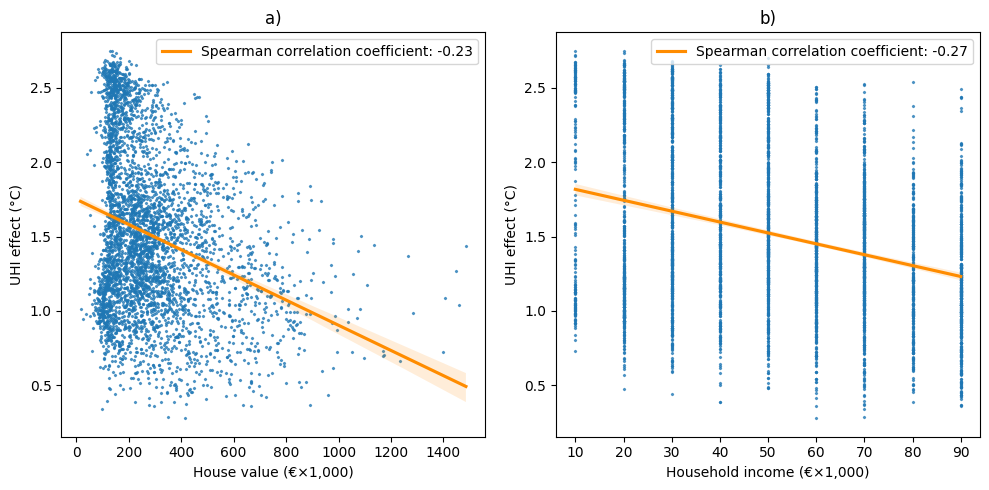

In [200]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the mean house value vs. the mean UHI effect
sns.regplot(
    x="house_value_mean_1000_eur",
    y="UHI_effect_mean_C",
    data=census_blocks_subset,
    ax=axes[0],
    line_kws={"label": f"Spearman correlation coefficient: {corr_house_value:.2f}", "color": "darkorange"},
    marker="x",
    scatter_kws={"s": 2},
)
axes[0].set_title("a)")
axes[0].set_xlabel("House value (€×1,000)")
axes[0].set_ylabel("UHI effect (°C)")
axes[0].legend()

# Plot the median household income vs. the mean UHI effect
sns.regplot(
    x="household_income_median_1000_eur",
    y="UHI_effect_mean_C",
    data=census_blocks_subset,
    ax=axes[1],
    line_kws={"label": f"Spearman correlation coefficient: {corr_income:.2f}", "color": "darkorange"},
    marker="x",
    scatter_kws={"s": 2},
)
axes[1].set_title("b)")
axes[1].set_xlabel("Household income (€×1,000)")
axes[1].set_ylabel("UHI effect (°C)")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.savefig(f"data/output/images/GIS/economic_status_vs_UHI_scatter_census_blocks_100m.png", dpi=300, bbox_inches="tight")
plt.show()

#### Scatterplots (using matplotlib)

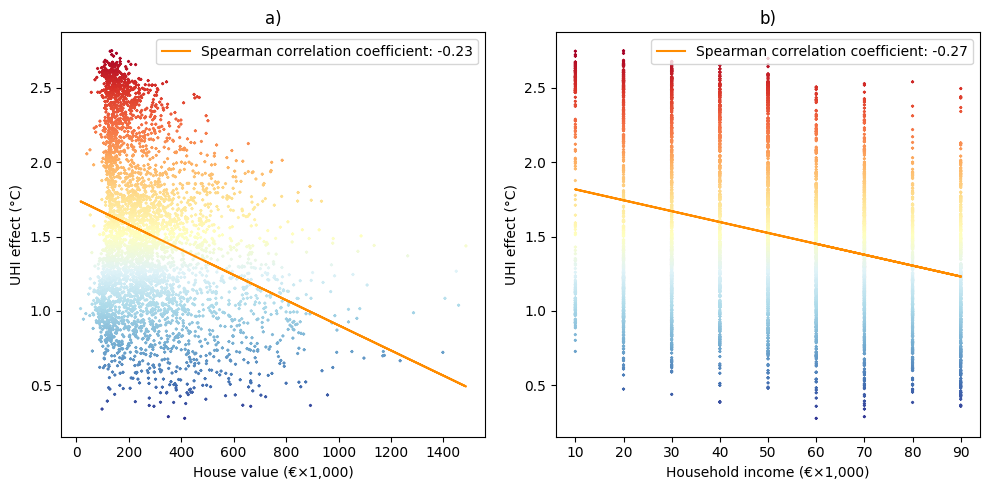

In [203]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the mean house value vs. the mean UHI effect
x1 = census_blocks_subset["house_value_mean_1000_eur"]
y1 = census_blocks_subset["UHI_effect_mean_C"]
axes[0].scatter(x1, y1, marker="x", s=2, c=y1, cmap="RdYlBu_r")

# Fit and plot a linear regression line
coeff1 = np.polyfit(x1, y1, 1)
line1 = coeff1[0] * x1 + coeff1[1]
axes[0].plot(x1, line1, color="darkorange", label=f"Spearman correlation coefficient: {corr_house_value:.2f}")

# Customize subplot 0
axes[0].set_title("a)")
axes[0].set_xlabel("House value (€×1,000)")
axes[0].set_ylabel("UHI effect (°C)")
axes[0].legend()

# Plot the median household income vs. the mean UHI effect
x2 = census_blocks_subset["household_income_median_1000_eur"]
y2 = census_blocks_subset["UHI_effect_mean_C"]
axes[1].scatter(x2, y2, marker="x", s=2, c=y2, cmap="RdYlBu_r")

# Fit and plot a linear regression line
coeff2 = np.polyfit(x2, y2, 1)
line2 = coeff2[0] * x2 + coeff2[1]
axes[1].plot(x2, line2, color="darkorange", label=f"Spearman correlation coefficient: {corr_income:.2f}")

# Customize subplot 1
axes[1].set_title("b)")
axes[1].set_xlabel("Household income (€×1,000)")
axes[1].set_ylabel("UHI effect (°C)")
axes[1].legend(loc="upper right")

# Adjust layout
plt.tight_layout()

# Save the plot as an image
plt.savefig(f"data/output/images/GIS/economic_status_vs_UHI_scatter_census_blocks_100m.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

#### Boxplots of household income vs UHI effect

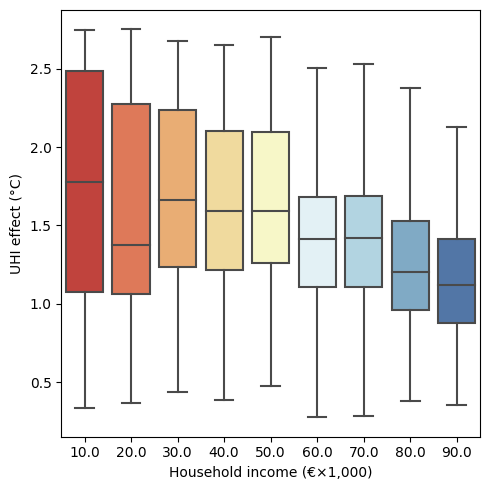

In [193]:
# Create a boxplot of UHI values for each value of the median household income
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(x="household_income_median_1000_eur", y="UHI_effect_mean_C", data=census_blocks, fliersize=0, palette="RdYlBu")
plt.xlabel("Household income (€×1,000)")
plt.ylabel("UHI effect (°C)")
plt.tight_layout()
plt.savefig(f"data/output/images/GIS/household_income_vs_UHI_boxplot_census_blocks_100m.png", dpi=300, bbox_inches="tight")
plt.show()

# 3 Analyzing CDM results

#### Define path and layer names

In [3]:
BUILDING_SUBSET_NAME = "full"  # The name of the subset of buildings to be used ('sample': 314 buildings, 'subset': 5000 buildings, or 'full': all buildings)')
SCENARIO = "SQ"  # The scenario to be used ('SQ' (Status Quo), '2030', 2050_L, '2050_M', 2050_H)

buildings_CDM_path = Path(f"data/output/geodata/buildings_with_CDM_results_{SCENARIO}_{BUILDING_SUBSET_NAME}.gpkg")  # The path to the GeoPackage containing CDM results
buildings_CDM_layer = f"buildings_with_CDM_results_{SCENARIO}_{BUILDING_SUBSET_NAME}"  # The name of the layer within the GeoPackage

# Define path names for geographic divisions
geographic_divisions_path = Path("data/input/geodata/GeographicDivisions_TheHague.gpkg")
census_blocks_layer = "Census_blocks_100m_TheHague"
postcode_layer = "PostCodes_TheHague"
districts_layer = "Districts_TheHague"
neighborhoods_layer = "Neighbourhoods_TheHague"
outline_layer = "Outline_TheHague"

#### Read in geodata

In [4]:
# Load the buildings with CDM results
buildings_CDM = gpd.read_file(filename=buildings_CDM_path, layer=buildings_CDM_layer)

In [ ]:
# Load the GeoPackage with the geographic divisions
census_blocks = gpd.read_file(filename=geographic_divisions_path, layer=census_blocks_layer)  # The 100 x 100m Dutch census blocks
postcodes = gpd.read_file(filename=geographic_divisions_path, layer=postcode_layer)  # The 4-digit postcode districts
districts = gpd.read_file(filename=geographic_divisions_path, layer=districts_layer)  # The districts (wijken)
neighborhoods = gpd.read_file(filename=geographic_divisions_path, layer=neighborhoods_layer)  # The neighborhoods (buurten)
outline_TH = gpd.read_file(filename=geographic_divisions_path, layer=outline_layer)  # The outline of The Hague

#### Alternative: read scaled results DataFrame

In [ ]:
# Load the buildings with CDM results, scaled with building stock growth
buildings_CDM = pd.read_csv(f"data/output/CDM_results_{SCENARIO}_{BUILDING_SUBSET_NAME}.csv")

## 3.1 Building type and energy labels

In [ ]:
# Create a new column with the floor area in hectares
buildings_CDM["floor_area_total_ha"] = buildings_CDM["floor_area_total_m2"] / 10_000

### Building types

In [ ]:
# Create a new column building type print, which is the string join of building type int and building type
buildings_CDM["building_type_print"] = buildings_CDM["building_type_int"].astype("str") + ": " + buildings_CDM["building_type"]

#### Histograms

In [ ]:
floor_space_per_building_type = buildings_CDM.groupby("building_type_print")["floor_area_total_ha"].sum().sort_index()  # Calculate total floor space per energy label in ha

colors = plt.cm.tab10(np.linspace(0, 1, len(floor_space_per_building_type)))  # Give every building type a different color

plt.figure(figsize=(10, 6))
plt.bar(floor_space_per_building_type.index, floor_space_per_building_type.values, color=colors)
plt.title("Distribution of building types")
plt.xlabel("Building type")
plt.xticks(rotation=60, fontsize=9, ha="right")
plt.ylabel("Floor space (ha)")
plt.savefig(f"data/output/images/histogram_building_types_floor_space_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### Maps - Census blocks 100 x 100m

In [ ]:
# Join the buildings and census blocks GeoDataFrames
joined_buildings_census_blocks = gpd.sjoin(buildings_CDM, census_blocks)

# Group by census block and building type and sum the floor area
census_blocks_building_types = joined_buildings_census_blocks.groupby(["index_right", "building_type_print"])["floor_area_total_m2"].sum().reset_index()

# Determine the dominant building type per census block
idx = census_blocks_building_types.groupby("index_right")["floor_area_total_m2"].idxmax()
prevalent_building_types_per_census_block = census_blocks_building_types.loc[idx].set_index("index_right")["building_type_print"]

# Join the dominant building types back to the census block DataFrame
census_blocks = census_blocks.merge(prevalent_building_types_per_census_block, left_index=True, right_index=True, how="left")

In [ ]:
# Now we can plot the census blocks with the building types
ax = census_blocks.plot(column="building_type_print", cmap="tab10", legend=True, figsize=(10, 10))
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Most prevalent building type per grid cell")
ax.set_axis_off()
plt.savefig(f"data/output/images/GIS/GIS_building_types_100_100_m_grid_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### Maps - neighborhoods

In [ ]:
# Join the buildings and neighborhoods GeoDataFrames
joined_buildings_neighborhoods = gpd.sjoin(buildings_CDM, neighborhoods)

# Group by neighborhood and building type and sum the floor area
neighborhoods_building_types = joined_buildings_neighborhoods.groupby(["index_right", "building_type_print"])["floor_area_total_m2"].sum().reset_index()

# Determine the dominant building type per neighborhood
idx = neighborhoods_building_types.groupby("index_right")["floor_area_total_m2"].idxmax()
prevalent_building_types_per_neighborhood = neighborhoods_building_types.loc[idx].set_index("index_right")["building_type_print"]

# Join the dominant building types back to the neighborhood DataFrame
neighborhoods = neighborhoods.merge(prevalent_building_types_per_neighborhood, left_index=True, right_index=True, how="left")

In [ ]:
# HACK Add dummy rows to the neighborhoods GeoDataFrame for color consistency across plots
for building_type in buildings_CDM["building_type_print"].unique():
    if building_type not in neighborhoods["building_type_print"].values:
        dummy_data = {col: None for col in neighborhoods.columns}
        dummy_data["building_type_print"] = building_type
        neighborhoods.loc[len(neighborhoods)] = dummy_data

In [ ]:
# Now we can plot the neighborhoods with the building types
ax = neighborhoods.plot(column="building_type_print", cmap="tab10", legend=True, figsize=(10, 10))
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Most prevalent building type per neighborhood")
ax.set_axis_off()
plt.savefig(f"data/output/images/GIS/GIS_building_types_neighborhoods_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

### Energy labels

In [ ]:
# Create a new column energy_class_int by mapping the energy_class column to the ENERGY_CLASS_TO_INT dictionary
buildings_CDM["energy_class_int"] = buildings_CDM["energy_class"].map(ENERGY_CLASS_TO_INT)

# Reorder the energy label column to be in the correct order
energy_label_order = list(ENERGY_LABEL_TO_INT.keys())
buildings_CDM["energy_label"] = pd.Categorical(buildings_CDM["energy_label"], categories=energy_label_order, ordered=True)

#### Histograms

In [ ]:
# Plot a histogram of the energy labels
labels = buildings_CDM["energy_label"].cat.categories  # Get ordered energy labels
values = buildings_CDM["energy_label"].value_counts(sort=False)[labels].fillna(0)  # Get count of energy labels and fill missing values with 0

# Create a color map from green to red based on the number of unique labels
colors = plt.cm.RdYlGn_r(np.linspace(0, 1, len(labels)))

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors)
plt.title("Distribution of energy labels")
plt.xlabel("Energy label")
plt.ylabel("Building count")
plt.savefig(f"data/output/images/histogram_energy_labels_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
floor_space_per_energy_label = buildings_CDM.groupby("energy_label")["floor_area_total_m2"].sum() / 10_000  # Calculate total floor space per energy label in ha

# Plot a histogram of the energy labels by floor space
labels = buildings_CDM["energy_label"].cat.categories  # Get ordered energy labels
values = floor_space_per_energy_label[labels].fillna(0)  # Get count of energy labels and fill missing values with 0

# Create a color map from green to red based on the number of unique labels
colors = plt.cm.RdYlGn_r(np.linspace(0, 1, len(labels)))

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors)
plt.title("Distribution of energy labels")
plt.xlabel("Energy label")
plt.ylabel("Floor space (ha)")
plt.savefig(f"data/output/images/histogram_energy_labels_floor_space_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Determine the floor space per energy label per building type
energy_labels_per_building_type = buildings_CDM.groupby(["building_type_print", "energy_label"])["floor_area_total_m2"].sum().unstack().fillna(0)

# Normalize the floor spaces per building type
energy_labels_per_building_type_norm = energy_labels_per_building_type.div(energy_labels_per_building_type.sum(axis=1), axis=0)

# Create a color map from green to red based on the number of unique labels
colors = plt.cm.RdYlGn_r(np.linspace(0, 1, len(buildings_CDM["energy_label"].cat.categories)))

energy_labels_per_building_type_norm.plot.bar(stacked=True, figsize=(10, 6), color=colors, legend=True)

plt.title("Distribution of energy labels per building type")
plt.xlabel("Building type")
plt.xticks(rotation=60, fontsize=9, ha="right")
plt.ylabel("Floor space (ha)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0)
plt.savefig(f"data/output/images/histogram_energy_labels_per_building_type_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Determine the floor space per energy class per building type
energy_classes_per_building_type = buildings_CDM.groupby(["building_type_print", "energy_class"])["floor_area_total_m2"].sum().unstack().fillna(0)

# Normalize the floor spaces per building type
energy_classes_per_building_type_norm = energy_classes_per_building_type.div(energy_classes_per_building_type.sum(axis=1), axis=0)

# Create a color map from green to red based on the number of unique classes
colors = plt.cm.RdYlGn_r(np.linspace(0, 1, len(buildings_CDM["energy_class"].unique())))

energy_classes_per_building_type_norm.plot.bar(stacked=True, figsize=(10, 6), color=colors, legend=True)

plt.title("Distribution of energy classes per building type")
plt.xlabel("Building type")
plt.xticks(rotation=60, fontsize=9, ha="right")
plt.ylabel("Floor space (ha)")
plt.legend()
plt.savefig(f"data/output/images/histogram_energy_classes_per_building_type_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### Maps - Census blocks 100 x 100m

In [ ]:
# Join the buildings and census blocks GeoDataFrames
joined_buildings_census_blocks = gpd.sjoin(buildings_CDM, census_blocks)

# Calculate the mean energy label per census block, weighted by floor area of the buildings.
mean_energy_label_per_census_block = (
    joined_buildings_census_blocks.groupby("index_right").apply(lambda x: round(np.average(x["energy_label_int"], weights=x["floor_area_total_m2"]))).reset_index()
)

# Rename columns and reset index for merging back to the census block DataFrame
mean_energy_label_per_census_block = mean_energy_label_per_census_block.rename(columns={0: "energy_label_int"})
mean_energy_label_per_census_block = mean_energy_label_per_census_block.set_index("index_right")

# Join the mean energy labels to the census block  DataFrame
census_blocks = census_blocks.merge(mean_energy_label_per_census_block, left_index=True, right_index=True, how="left")

# Convert the energy labels back to text: 1: A+++++, 2: A++++, etc.
int_to_energy_label = {v: k for k, v in ENERGY_LABEL_TO_INT.items()}
census_blocks["energy_label"] = census_blocks["energy_label_int"].replace(int_to_energy_label)

# Explicitly order the new energy label column
energy_label_order = [label for label in energy_label_order if label in census_blocks["energy_label"].unique()]
census_blocks["energy_label"] = pd.Categorical(census_blocks["energy_label"], categories=energy_label_order, ordered=True)

In [ ]:
# Now we can plot the census blocks with the energy labels
ax = census_blocks.plot(column="energy_label", cmap="RdYlGn_r", legend=True, figsize=(10, 10))
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Average energy label per grid cell")
ax.set_axis_off()
plt.savefig(f"data/output/images/GIS_energy_labels_100_100_m_grid_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Map the energy labels to energy classes
energy_label_to_energy_class = {
    "A+++++": "A - A+++++",
    "A++++": "A - A+++++",
    "A+++": "A - A+++++",
    "A++": "A - A+++++",
    "A+": "A - A+++++",
    "A": "A - A+++++",
    "B": "B - C",
    "C": "B - C",
    "D": "D - E",
    "E": "D - E",
    "F": "F - G",
    "G": "F - G",
}

census_blocks["energy_class"] = census_blocks["energy_label"].map(energy_label_to_energy_class)

# Plot the census blocks with the energy classes
ax = census_blocks.plot(column="energy_class", cmap="RdYlGn_r", legend=True, figsize=(10, 10))
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Average energy class per grid cell")
ax.set_axis_off()
plt.savefig(f"data/output/images/GIS/GIS_energy_classes_100_100_m_grid_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### Maps - neighborhoods

In [ ]:
# Join the buildings and neighborhoods GeoDataFrames
joined_buildings_neighborhoods = gpd.sjoin(buildings_CDM, neighborhoods)

# Calculate the mean energy label per neighborhood, weighted by floor area of the buildings.
mean_energy_label_per_neighborhood = (
    joined_buildings_neighborhoods.groupby("index_right").apply(lambda x: round(np.average(x["energy_label_int"], weights=x["floor_area_total_m2"]))).reset_index()
)

# Rename columns and reset index for merging back to the neighborhood DataFrame
mean_energy_label_per_neighborhood = mean_energy_label_per_neighborhood.rename(columns={0: "energy_label_int"})
mean_energy_label_per_neighborhood = mean_energy_label_per_neighborhood.set_index("index_right")

# Join the mean energy labels to the neighborhood  DataFrame
neighborhoods = neighborhoods.merge(mean_energy_label_per_neighborhood, left_index=True, right_index=True, how="left")

# Convert the energy labels back to text: 1: A+++++, 2: A++++, etc.
int_to_energy_label = {v: k for k, v in ENERGY_LABEL_TO_INT.items()}
neighborhoods["energy_label"] = neighborhoods["energy_label_int"].replace(int_to_energy_label)

# Explicitly order the new energy label column
energy_label_order = list(ENERGY_LABEL_TO_INT.keys())
energy_label_order = [label for label in energy_label_order if label in neighborhoods["energy_label"].unique()]
neighborhoods["energy_label"] = pd.Categorical(neighborhoods["energy_label"], categories=energy_label_order, ordered=True)

# Don't show entries that dont appear on the map
neighborhoods = neighborhoods.dropna(subset=["energy_label"])

In [ ]:
# Create a color map from green to red based on the number of unique labels
cmap = plt_colors.ListedColormap(plt.cm.RdYlGn_r(np.linspace(0.3, 0.85, len(neighborhoods["energy_label"].cat.categories))))

In [ ]:
# Now we can plot the neighborhoods with the energy labels
ax = neighborhoods.plot(column="energy_label", cmap=cmap, legend=True, figsize=(10, 10))
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Average energy label per neighborhood")
ax.set_axis_off()
plt.savefig(f"data/output/images/GIS/GIS_energy_labels_neighborhoods_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
neighborhoods["energy_class"] = neighborhoods["energy_label"].map(energy_label_to_energy_class)

# Plot the census blocks with the energy classes
ax = neighborhoods.plot(column="energy_class", cmap="RdYlGn_r", legend=True, figsize=(10, 10))
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Average energy class per neighborhood")
ax.set_axis_off()
plt.savefig(f"data/output/images/GIS/GIS_energy_classes_neighborhoods_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### Heatmap of offices not fulfilling energy label requirements

In [ ]:
# Find office buildings with energy label below C (8 in integer value) larger than 100 m2
office_buildings = buildings_CDM[buildings_CDM["end_use"] == "office"]
office_buildings_larger_than_100_m2 = office_buildings[office_buildings["floor_area_total_m2"] > 100]
office_buildings_below_C = office_buildings_larger_than_100_m2[office_buildings_larger_than_100_m2["energy_label_int"] > 8]

In [ ]:
# Print results
print(f"Number of office buildings with energy label below C larger than 100 m2: {len(office_buildings_below_C)}")
print(f"Share of total office buildings: {round(len(office_buildings_below_C)/len(office_buildings) * 100)}%")
print(f"Floor area of office buildings with energy label below C larger than 100 m2: {office_buildings_below_C['floor_area_total_m2'].sum()} m2")
print(f"Share of total floor area of office buildings: {round(office_buildings_below_C['floor_area_total_m2'].sum()/office_buildings['floor_area_total_m2'].sum() * 100)}%")

In [ ]:
# Join the offices and neighborhoods GeoDataFrames
joined_offices_neighborhoods = gpd.sjoin(office_buildings, neighborhoods)

# Calculate the total floor area of offices per neighborhood
floor_area_offices_per_neighborhood = joined_offices_neighborhoods.groupby("index_right")["floor_area_total_m2"].sum().reset_index()

# Join the offices not adhering to the energy label C and neighborhoods GeoDataFrames
joined_offices_below_C_neighborhoods = gpd.sjoin(office_buildings_below_C, neighborhoods)

# Calculate the total floor area of office buildings with energy label below C per neighborhood
floor_area_offices_below_C_per_neighborhood = joined_offices_below_C_neighborhoods.groupby("index_right")["floor_area_total_m2"].sum().reset_index()

In [ ]:
# Rename columns
floor_area_offices_per_neighborhood = floor_area_offices_per_neighborhood.rename(columns={"floor_area_total_m2": "floor_area_offices_m2"})
floor_area_offices_below_C_per_neighborhood = floor_area_offices_below_C_per_neighborhood.rename(columns={"floor_area_total_m2": "floor_area_offices_below_C_m2"})

# Reset index for merging back to the neighborhood DataFrame
floor_area_offices_per_neighborhood = floor_area_offices_per_neighborhood.set_index("index_right")
floor_area_offices_below_C_per_neighborhood = floor_area_offices_below_C_per_neighborhood.set_index("index_right")

# Join the floor areas back to the neighborhood DataFrame
neighborhoods = neighborhoods.merge(floor_area_offices_per_neighborhood, left_index=True, right_index=True, how="left")
neighborhoods = neighborhoods.merge(floor_area_offices_below_C_per_neighborhood, left_index=True, right_index=True, how="left")

In [ ]:
# Fill floor_area_offices_below_C_m2 with 0 where there are no office buildings with energy label below C
neighborhoods["floor_area_offices_below_C_m2"] = neighborhoods["floor_area_offices_below_C_m2"].fillna(0)

# Create a new column with the percentage of office buildings that adhere to the minimum energy label rules (by floor area)
neighborhoods["share_offices_adhering_to_rules"] = (1 - neighborhoods["floor_area_offices_below_C_m2"] / neighborhoods["floor_area_offices_m2"]) * 100

In [ ]:
# Define parameters for the colorbar's appearance
legend_kwds = {
    "label": "Share of total office building floor space (%)",
    "shrink": 0.5,
}

# Now plot the share of office buildings with energy label below C per neighborhood
ax = neighborhoods.plot(column="share_offices_adhering_to_rules", legend=True, cmap="RdYlGn", figsize=(8, 8), legend_kwds=legend_kwds)
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Share of office buildings adhering to minimum energy label\nrequirements per neighborhood")
ax.set_axis_off()

plt.savefig(f"data/output/images/GIS_share_offices_below_C_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

### Height and age

In [ ]:
# Plot a histogram of the height of the buildings, with the height class cutoff at 17.5 m
plt.figure(figsize=(6, 4))
plt.hist(buildings_CDM["height_m"], range=(0, 100), bins=100)
plt.axvline(x=17.5, color="red", linestyle="--", label="Height class cutoff (17.5 m)")
plt.title("Distribution of building heights")
plt.xlabel("Building height (m)")
plt.ylabel("Building count")
plt.legend()
plt.tight_layout()
plt.savefig(f"data/output/images/histogram_building_heights_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Plot the distribution of building height, weighted by floor area
plt.figure(figsize=(6, 4))
plt.hist(buildings_CDM["height_m"], bins=100, range=(0, 100), weights=buildings_CDM["floor_area_total_m2"] / 10_000)
plt.axvline(x=17.5, color="red", linestyle="--", label="Height class cutoff (17.5 m)")
plt.title("Distribution of building heights")
plt.xlabel("Building height (m)")
plt.ylabel("Floor space (ha)")
plt.legend()
plt.tight_layout()
plt.savefig(f"data/output/images/histogram_building_heights_floor_space_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(6, 4))
sns.kdeplot(data=buildings_CDM, x="height_m", weights=buildings_CDM["floor_area_total_m2"], fill=True)
plt.axvline(x=17.5, color="red", linestyle="--", label="Height class cutoff (17.5 m)")
plt.title("Distribution of building heights")
plt.xlabel("Building height (m)")
plt.ylabel("Fraction of floor space")
plt.xlim(0, 100)
plt.legend()
plt.tight_layout()
plt.savefig(f"data/output/images/kdeplot_building_heights_floor_space_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Plot a histogram of the construction year of the buildings, with the age class cutoff at 2003
plt.figure(figsize=(6, 4))
plt.hist(buildings_CDM["construction_year"], bins=100)
plt.axvline(x=2003, color="red", linestyle="--", label="Age class cutoff (2003)")
plt.title("Distribution of building ages")
plt.xlabel("Construction year")
plt.ylabel("Building count")
plt.legend()
plt.tight_layout()
plt.savefig(f"data/output/images/histogram_building_ages_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Plot the distribution of construction year, weighted by floor area
plt.figure(figsize=(6, 4))
plt.hist(buildings_CDM["construction_year"], bins=80, range=(1800, 2023), weights=buildings_CDM["floor_area_total_m2"] / 10_000)
plt.axvline(x=2003, color="red", linestyle="--", label="Age class cutoff (2003)")
plt.title("Distribution of building ages")
plt.xlabel("Construction year")
plt.ylabel("Floor space (ha)")
plt.legend()
plt.tight_layout()
plt.savefig(f"data/output/images/histogram_building_ages_floor_space_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(6, 4))
sns.kdeplot(data=buildings_CDM, x="construction_year", weights=buildings_CDM["floor_area_total_m2"], fill=True)
plt.axvline(x=2003, color="red", linestyle="--", label="Age class cutoff (2003)")
plt.title("Distribution of building ages")
plt.xlabel("Construction year")
plt.ylabel("Fraction of floor space")
plt.xlim(1800, 2035)
plt.legend()
plt.tight_layout()
plt.savefig(f"data/output/images/kdeplot_building_ages_floor_space_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### Age vs. energy label

In [ ]:
plt.figure(figsize=(6, 4))

colors = plt.cm.RdYlGn(np.linspace(0, 1, len(buildings_CDM["energy_class"].unique())))

# Plot KDE for each energy class
for energy_class, color in zip(buildings_CDM["energy_class"].unique(), colors, strict=True):
    subset = buildings_CDM[buildings_CDM["energy_class"] == energy_class]
    sns.kdeplot(data=subset, x="construction_year", weights=subset["floor_area_total_m2"], label=energy_class, fill=True, color=color, alpha=0.5)

plt.axvline(x=2003, color="red", linestyle="--", label="Age class cutoff (2003)")
plt.title("Distribution of building ages per energy class")
plt.xlabel("Construction year")
plt.ylabel("Floor space density")
plt.xlim(1800, 2035)
plt.legend()
plt.tight_layout()
plt.savefig(f"data/output/images/kdeplot_building_age_per_energy_label_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### Maps - Census blocks 100 x 100m

In [ ]:
# Join the buildings and census blocks GeoDataFrames
joined_buildings_census_blocks = gpd.sjoin(buildings_CDM, census_blocks)

# Calculate the mean construction year per census block, weighted by floor area of the buildings.
mean_construction_year_per_census_block = (
    joined_buildings_census_blocks.groupby("index_right").apply(lambda x: round(np.average(x["construction_year"], weights=x["floor_area_total_m2"]))).reset_index()
)

# Rename columns and reset index for merging back to the census block DataFrame
mean_construction_year_per_census_block = mean_construction_year_per_census_block.rename(columns={0: "construction_year"})
mean_construction_year_per_census_block = mean_construction_year_per_census_block.set_index("index_right")

# Join the mean construction years to the census block  DataFrame
census_blocks = census_blocks.merge(mean_construction_year_per_census_block, left_index=True, right_index=True, how="left")

# Now we can plot the census blocks with the construction years
ax = census_blocks.plot(column="construction_year", legend=True, figsize=(8, 8))
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Average construction year per grid cell")
ax.set_axis_off()
plt.savefig(f"data/output/images/GIS_construction_years_100_100_m_grid_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### Maps - Neighborhoods

In [ ]:
# Join the buildings and neighborhoods GeoDataFrames
joined_buildings_neighborhoods = gpd.sjoin(buildings_CDM, neighborhoods)

# Calculate the mean construction year per neighborhood, weighted by floor area of the buildings.
mean_construction_year_per_neighborhood = (
    joined_buildings_neighborhoods.groupby("index_right").apply(lambda x: round(np.average(x["construction_year"], weights=x["floor_area_total_m2"]))).reset_index()
)

# Rename columns and reset index for merging back to the neighborhood DataFrame
mean_construction_year_per_neighborhood = mean_construction_year_per_neighborhood.rename(columns={0: "construction_year"})
mean_construction_year_per_neighborhood = mean_construction_year_per_neighborhood.set_index("index_right")

# Join the mean construction years to the neighborhood  DataFrame
neighborhoods = neighborhoods.merge(mean_construction_year_per_neighborhood, left_index=True, right_index=True, how="left")

In [ ]:
# Define parameters for the colorbar's appearance
legend_kwds = {
    "label": "Construction Year",
    "shrink": 0.5,
}

# Now we can plot the neighborhoods with the construction years
ax = neighborhoods.plot(column="construction_year", legend=True, figsize=(8, 8), legend_kwds=legend_kwds)
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Average construction year per neighborhood")
ax.set_axis_off()
plt.savefig(f"data/output/images/GIS_construction_years_neighborhoods_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

## 3.2 Cooling energy and power demand

### By building type

In [ ]:
# Create a new column with the floor area in hectares
buildings_CDM["floor_area_total_ha"] = buildings_CDM["floor_area_total_m2"] / 10_000

In [ ]:
# Create a new column building type print, which is the string join of building type int and building type
buildings_CDM["building_type_print"] = buildings_CDM["building_type_int"].astype("str") + ": " + buildings_CDM["building_type"]

# For some reason, matplotlib handles colormaps differently than seaborn. I manually change the seaborn colormap to match the matplotlib one
tab10_colors = sns.color_palette("tab10", 10)

# Remove the 4th and 7th colors (remember, Python uses 0-based indexing)
adapted_tab10_colors = [color for i, color in enumerate(tab10_colors) if i not in [3, 6]]

#### Cooling energy demand

In [ ]:
buildings_CDM["E_cooling_capped_at_98th_percentile_kWh_m2"] = buildings_CDM["E_cooling_capped_at_98th_percentile_Wh_m2"] / 1000

# HACK Rename "building_type_print" column for printing purposes
buildings_CDM = buildings_CDM.rename(columns={"building_type_print": "Building type:"})

# Plot the histogram using Seaborn's histplot
sns.histplot(
    data=buildings_CDM,
    x="E_cooling_capped_at_98th_percentile_kWh_m2",
    hue="Building type:",
    hue_order=sorted(buildings_CDM["Building type:"].unique()),
    palette=adapted_tab10_colors,
    weights="floor_area_total_ha",
    bins=75,
    multiple="stack",
)

# Set the title and labels
plt.title(f"Distribution of cooling energy demand intensity per building type ({SCENARIO.replace ('_', '')} scenario)")
plt.xlabel("Cooling energy demand intensity (kWh/m2)")
plt.ylabel("Floor space (ha)")
plt.xlim(0, 200)
plt.savefig(f"data/output/images/histogram_cooling_energy_demand_intensity_per_building_type_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

# HACK Revert renaming of "building_type_print" column
buildings_CDM = buildings_CDM.rename(columns={"Building type:": "building_type_print"})

#### Peak cooling power demand

In [ ]:
# HACK Rename "building_type_print" column for printing purposes
buildings_CDM = buildings_CDM.rename(columns={"building_type_print": "Building type:"})

# Plot the histogram using Seaborn's histplot
sns.histplot(
    data=buildings_CDM,
    x="P_cooling_peak_98th_percentile_W_m2",
    hue="Building type:",
    hue_order=sorted(buildings_CDM["Building type:"].unique()),
    palette=adapted_tab10_colors,
    weights="floor_area_total_ha",
    bins=75,
    multiple="stack",
)

# Set the title and labels
plt.title("Peak cooling power demand intensity (98th percentile) per building type")
plt.xlabel("Peak cooling power demand intensity (W/m2)")
plt.ylabel("Floor space (ha)")
plt.xlim(0, 200)
plt.savefig(f"data/output/images/histogram_cooling_power_demand_intensity_per_building_type_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

# HACK Revert renaming of "building_type_print" column
buildings_CDM = buildings_CDM.rename(columns={"Building type:": "building_type_print"})

#### Correlation between population and energy demand

In [ ]:
# Plot the correlation between the population in a building and the energy demand
plt.figure(figsize=(6, 4))
plt.scatter(buildings_CDM["population"], buildings_CDM["floor_area_total_m2"], alpha=0.1)
plt.title("Correlation between population and energy demand")

In [ ]:
# Plot the correlation between the population in a building and the energy demand
plt.figure(figsize=(6, 4))
plt.scatter(
    buildings_CDM[buildings_CDM["building_type_int"].isin([1, 2, 3, 4])]["population"],
    buildings_CDM[buildings_CDM["building_type_int"].isin([1, 2, 3, 4])]["E_cooling_kWh"],
    alpha=0.1,
)
plt.scatter(
    buildings_CDM[buildings_CDM["building_type_int"].isin([5, 6, 7, 8])]["population"],
    buildings_CDM[buildings_CDM["building_type_int"].isin([5, 6, 7, 8])]["E_cooling_kWh"],
    alpha=0.1,
)

# Plot the trend line for both building types
plt.plot(
    np.unique(buildings_CDM[buildings_CDM["building_type_int"].isin([1, 2, 3, 4])]["population"]),
    np.poly1d(
        np.polyfit(
            buildings_CDM[buildings_CDM["building_type_int"].isin([1, 2, 3, 4])]["population"],
            buildings_CDM[buildings_CDM["building_type_int"].isin([1, 2, 3, 4])]["E_cooling_kWh"],
            1,
        ),
    )(np.unique(buildings_CDM[buildings_CDM["building_type_int"].isin([1, 2, 3, 4])]["population"])),
    color="blue",
)
plt.plot(
    np.unique(buildings_CDM[buildings_CDM["building_type_int"].isin([5, 6, 7, 8])]["population"]),
    np.poly1d(
        np.polyfit(
            buildings_CDM[buildings_CDM["building_type_int"].isin([5, 6, 7, 8])]["population"],
            buildings_CDM[buildings_CDM["building_type_int"].isin([5, 6, 7, 8])]["E_cooling_kWh"],
            1,
        ),
    )(np.unique(buildings_CDM[buildings_CDM["building_type_int"].isin([5, 6, 7, 8])]["population"])),
    color="orange",
)

# Show the correlation coefficient for both building types
plt.text(
    0.5,
    0.9,
    f"Residential: {round(buildings_CDM[buildings_CDM['building_type_int'].isin([1,2,3,4])]['population'].corr(buildings_CDM[buildings_CDM['building_type_int'].isin([1,2,3,4])]['E_cooling_kWh']), 2)}",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
    color="blue",
)
plt.text(
    0.5,
    0.85,
    f"Non-residential: {round(buildings_CDM[buildings_CDM['building_type_int'].isin([5,6,7,8])]['population'].corr(buildings_CDM[buildings_CDM['building_type_int'].isin([5,6,7,8])]['E_cooling_kWh']), 2)}",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
    color="orange",
)

# Set the title and labels
plt.legend(["Residential", "Non-residential"])
plt.xlabel("Population")
plt.ylabel("Cooling energy demand (kWh)")
plt.title("Correlation between population and energy demand")

In [ ]:
# Plot the correlation between the floor area in a building and the energy demand
plt.figure(figsize=(6, 4))
plt.scatter(
    buildings_CDM[buildings_CDM["building_type_int"].isin([1, 2, 3, 4])]["floor_area_total_m2"],
    buildings_CDM[buildings_CDM["building_type_int"].isin([1, 2, 3, 4])]["E_cooling_kWh"],
    alpha=0.1,
)
plt.scatter(
    buildings_CDM[buildings_CDM["building_type_int"].isin([5, 6, 7, 8])]["floor_area_total_m2"],
    buildings_CDM[buildings_CDM["building_type_int"].isin([5, 6, 7, 8])]["E_cooling_kWh"],
    alpha=0.1,
)

# Plot the trend line for both building types
plt.plot(
    np.unique(buildings_CDM[buildings_CDM["building_type_int"].isin([1, 2, 3, 4])]["floor_area_total_m2"]),
    np.poly1d(
        np.polyfit(
            buildings_CDM[buildings_CDM["building_type_int"].isin([1, 2, 3, 4])]["floor_area_total_m2"],
            buildings_CDM[buildings_CDM["building_type_int"].isin([1, 2, 3, 4])]["E_cooling_kWh"],
            1,
        ),
    )(np.unique(buildings_CDM[buildings_CDM["building_type_int"].isin([1, 2, 3, 4])]["floor_area_total_m2"])),
    color="blue",
)
plt.plot(
    np.unique(buildings_CDM[buildings_CDM["building_type_int"].isin([5, 6, 7, 8])]["floor_area_total_m2"]),
    np.poly1d(
        np.polyfit(
            buildings_CDM[buildings_CDM["building_type_int"].isin([5, 6, 7, 8])]["floor_area_total_m2"],
            buildings_CDM[buildings_CDM["building_type_int"].isin([5, 6, 7, 8])]["E_cooling_kWh"],
            1,
        ),
    )(np.unique(buildings_CDM[buildings_CDM["building_type_int"].isin([5, 6, 7, 8])]["floor_area_total_m2"])),
    color="orange",
)

# Show the correlation coefficient for both building types
plt.text(
    0.5,
    0.9,
    f"Residential: {round(buildings_CDM[buildings_CDM['building_type_int'].isin([1,2,3,4])]['floor_area_total_m2'].corr(buildings_CDM[buildings_CDM['building_type_int'].isin([1,2,3,4])]['E_cooling_kWh']), 2)}",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
    color="blue",
)
plt.text(
    0.5,
    0.85,
    f"Non-residential: {round(buildings_CDM[buildings_CDM['building_type_int'].isin([5,6,7,8])]['floor_area_total_m2'].corr(buildings_CDM[buildings_CDM['building_type_int'].isin([5,6,7,8])]['E_cooling_kWh']), 2)}",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
    color="orange",
)

# Set the title and labels
plt.legend(["Residential", "Non-residential"])
plt.xlabel("Floor area (m2)")
plt.ylabel("Cooling energy demand (kWh)")
plt.title("Correlation between floor area and energy demand")

### By energy class

In [ ]:
# Get sorted unique energy classes
energy_classes = sorted(buildings_CDM["energy_class"].unique())

# Create colormap based on the number of unique energy classes
colors = plt.cm.RdYlGn_r(np.linspace(0, 1, len(energy_classes)))

# Map energy classes to colors
color_map = dict(zip(energy_classes, colors, strict=True))

#### Cooling energy demand

In [ ]:
# Plot the histogram using Seaborn's histplot
sns.histplot(
    data=buildings_CDM,
    x="E_cooling_capped_at_98th_percentile_kWh_m2",
    hue="energy_class",
    hue_order=sorted(buildings_CDM["energy_class"].unique()),
    palette=color_map,
    weights="floor_area_total_ha",
    bins=75,
    multiple="stack",
)

# Set the title and labels
plt.title("Cooling energy demand intensity (capped at 98th percentile) per energy class")
plt.xlabel("Cooling energy demand intensity (kWh/m2)")
plt.ylabel("Floor space (ha)")
plt.xlim(0, 200)
plt.savefig(f"data/output/images/histogram_cooling_energy_demand_intensity_per_energy_class_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### Peak cooling power demand

In [ ]:
# Plot the histogram using Seaborn's histplot
sns.histplot(
    data=buildings_CDM,
    x="P_cooling_peak_98th_percentile_W_m2",
    hue="energy_class",
    hue_order=sorted(buildings_CDM["energy_class"].unique()),
    palette=color_map,
    weights="floor_area_total_ha",
    bins=75,
    multiple="stack",
)

# Set the title and labels
plt.title("Peak cooling power demand intensity (98th percentile) per energy class")
plt.xlabel("Peak cooling power demand intensity (W/m2)")
plt.ylabel("Floor space (ha)")
plt.xlim(0, 200)
plt.savefig(f"data/output/images/histogram_cooling_power_demand_intensity_per_energy_class_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

### Maps - Census blocks 100 x 100m


In [ ]:
# Join the buildings and census blocks GeoDataFrames
joined_buildings_census_blocks = gpd.sjoin(buildings_CDM, census_blocks)

#### Cooling energy demand

In [ ]:
# Calculate the mean cooling energy demand per census block, weighted by floor area of the buildings.
mean_cooling_energy_demand_per_census_block = joined_buildings_census_blocks.groupby("index_right")["E_cooling_capped_at_98th_percentile_Wh_m2"].mean().reset_index()

# Reset index for merging back to the census block DataFrame
mean_cooling_energy_demand_per_census_block = mean_cooling_energy_demand_per_census_block.set_index("index_right")

# Join the mean cooling energy demands to the census block DataFrame
census_blocks = census_blocks.merge(mean_cooling_energy_demand_per_census_block, left_index=True, right_index=True, how="left")

# Create a new column with the energy demand intensity in kWh per m2
census_blocks["E_cooling_capped_at_98th_percentile_kWh_m2"] = census_blocks["E_cooling_capped_at_98th_percentile_Wh_m2"] / 1000

In [ ]:
# Define parameters for the colorbar's appearance
legend_kwds = {
    "label": "Cooling energy demand intensity (kWh/m2 floor space)",
    "shrink": 0.5,
}

# Now we can plot the census blocks with the cooling energy demands
ax = census_blocks.plot(column="E_cooling_capped_at_98th_percentile_kWh_m2", legend=True, figsize=(8, 8), legend_kwds=legend_kwds)
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Cooling energy demand (capped at 98th percentile)\nper grid cell")
ax.set_axis_off()
plt.savefig(f"data/output/images/GIS/GIS_cooling_energy_demands_100_100_m_grid_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### Peak cooling power demand

In [ ]:
# Calculate the mean cooling power demand per census block, weighted by floor area of the buildings.
mean_cooling_power_demand_per_census_block = joined_buildings_census_blocks.groupby("index_right")["P_cooling_peak_98th_percentile_W_m2"].mean().reset_index()

# Reset index for merging back to the census block DataFrame
mean_cooling_power_demand_per_census_block = mean_cooling_power_demand_per_census_block.set_index("index_right")

# Join the mean cooling power demands to the census block DataFrame
census_blocks = census_blocks.merge(mean_cooling_power_demand_per_census_block, left_index=True, right_index=True, how="left")

In [ ]:
# Define parameters for the colorbar's appearance
legend_kwds = {
    "label": "Peak cooling power demand intensity (W/m2 floor space)",
    "shrink": 0.5,
}

# Now we can plot the census blocks with the cooling power demands
ax = census_blocks.plot(column="P_cooling_peak_98th_percentile_W_m2", legend=True, figsize=(8, 8), legend_kwds=legend_kwds)
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Peak cooling power demand (98th percentile)\nper grid cell")
ax.set_axis_off()

plt.savefig(f"data/output/images/GIS/GIS_cooling_power_demands_100_100_m_grid_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

### Maps - Neighborhoods

In [ ]:
# Join the buildings and neighborhoods GeoDataFrames
joined_buildings_neighborhoods = gpd.sjoin(buildings_CDM, neighborhoods)

#### Cooling energy demand

In [ ]:
# Calculate the mean cooling energy demand per neighborhood, weighted by floor area of the buildings.
mean_cooling_energy_demand_per_neighborhood = joined_buildings_neighborhoods.groupby("index_right")["E_cooling_capped_at_98th_percentile_Wh_m2"].mean().reset_index()

# Reset index for merging back to the neighborhood DataFrame
mean_cooling_energy_demand_per_neighborhood = mean_cooling_energy_demand_per_neighborhood.set_index("index_right")

# Join the mean cooling energy demands to the neighborhood DataFrame
neighborhoods = neighborhoods.merge(mean_cooling_energy_demand_per_neighborhood, left_index=True, right_index=True, how="left")

# Create a new column with the energy demand intensity in kWh per m2
neighborhoods["E_cooling_capped_at_98th_percentile_kWh_m2"] = neighborhoods["E_cooling_capped_at_98th_percentile_Wh_m2"] / 1000

In [ ]:
# Define parameters for the colorbar's appearance
legend_kwds = {
    "label": "Cooling energy demand intensity (kWh/m2 floor space)",
    "shrink": 0.5,
}

# Now we can plot the neighborhoods with the cooling energy demands
ax = neighborhoods.plot(column="E_cooling_capped_at_98th_percentile_kWh_m2", legend=True, figsize=(8, 8), legend_kwds=legend_kwds)
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Cooling energy demand (capped at 98th percentile)\nper neighborhood")
ax.set_axis_off()

plt.savefig(f"data/output/images/GIS/GIS_cooling_energy_demands_neighborhood_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### Peak cooling power demand

In [ ]:
# Calculate the mean cooling power demand per neighborhood, weighted by floor area of the buildings.
mean_cooling_power_demand_per_neighborhood = joined_buildings_neighborhoods.groupby("index_right")["P_cooling_peak_98th_percentile_W_m2"].mean().reset_index()

# Reset index for merging back to the neighborhood DataFrame
mean_cooling_power_demand_per_neighborhood = mean_cooling_power_demand_per_neighborhood.set_index("index_right")

# Join the mean cooling power demands to the neighborhood DataFrame
neighborhoods = neighborhoods.merge(mean_cooling_power_demand_per_neighborhood, left_index=True, right_index=True, how="left")

In [ ]:
# Define parameters for the colorbar's appearance
legend_kwds = {
    "label": "Peak cooling power demand intensity (W/m2 floor space)",
    "shrink": 0.5,
}

# Now we can plot the neighborhoods with the cooling power demands
ax = neighborhoods.plot(column="P_cooling_peak_98th_percentile_W_m2", legend=True, figsize=(8, 8), legend_kwds=legend_kwds)
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Peak cooling power demand (98th percentile)\nper neighborhood")
ax.set_axis_off()

# Add y-axis label to the colorbar
colorbar = ax.get_figure().get_axes()[1]  # The colorbar is typically the second axes in the figure
colorbar.set_ylabel("Peak cooling power demand intensity (W/m2 floor space)", rotation=270, labelpad=15)

plt.savefig(f"data/output/images/GIS/GIS_cooling_power_demands_neighborhood_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

## 3.3 Environmental impacts

In [ ]:
# Create a new column with the floor area in hectares
buildings_CDM["floor_area_total_ha"] = buildings_CDM["floor_area_total_m2"] / 10_000

### By energy class

In [ ]:
# Get sorted unique energy classes

energy_classes = sorted(buildings_CDM["energy_class"].unique())

# Create colormap based on the number of unique energy classes
colors = plt.cm.RdYlGn_r(np.linspace(0, 1, len(energy_classes)))

# Map energy classes to colors
color_map = dict(zip(energy_classes, colors, strict=True))

#### Electricity use

In [ ]:
# Plot the histogram using Seaborn's histplot
sns.histplot(
    data=buildings_CDM,
    x="electricity_use_intensity_kWh_m2",
    hue="energy_class",
    hue_order=sorted(buildings_CDM["energy_class"].unique()),
    palette=color_map,
    weights="floor_area_total_ha",
    bins=25,
    multiple="stack",
)

# Set the title and labels
plt.title("Electricity use intensity per energy class")
plt.xlabel("Electricity use intensity (kWh/m2)")
plt.ylabel("Floor space (ha)")
plt.xlim(0, 30)
plt.savefig(f"data/output/images/histogram_electricity_use_intensity_per_energy_class_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### GHG emissions

In [ ]:
# Plot the histogram using Seaborn's histplot
sns.histplot(
    data=buildings_CDM,
    x="GHG_emissions_intensity_kgCO2eq_m2",
    hue="energy_class",
    hue_order=sorted(buildings_CDM["energy_class"].unique()),
    palette=color_map,
    weights="floor_area_total_ha",
    bins=25,
    multiple="stack",
)

# Set the title and labels
plt.title("GHG emission intensity per energy class")
plt.xlabel("GHG emission intensity (kgCO2e/m2)")
plt.ylabel("Floor space (ha)")
plt.xlim(0, 15)
plt.savefig(f"data/output/images/histogram_GHG_emission_intensity_per_energy_class_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### Material demand

In [ ]:
# Plot the histogram using Seaborn's histplot
sns.histplot(
    data=buildings_CDM,
    x="material_use_intensity_kg_m2",
    hue="energy_class",
    hue_order=sorted(buildings_CDM["energy_class"].unique()),
    palette=color_map,
    weights="floor_area_total_ha",
    bins=25,
    multiple="stack",
)

# Set the title and labels
plt.title("Material intensity per energy class")
plt.xlabel("Material intensity (kg/m2)")
plt.ylabel("Floor space (ha)")
plt.xlim(0, 1.2)
plt.savefig(f"data/output/images/histogram_material_use_intensity_per_energy_class_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

### By building type

In [ ]:
# Create a new column building type print, which is the string join of building type int and building type
buildings_CDM["building_type_print"] = buildings_CDM["building_type_int"].astype("str") + ": " + buildings_CDM["building_type"]

# For some reason, matplotlib handles colormaps differently than seaborn. I manually change the seaborn colormap to match the matplotlib one
tab10_colors = sns.color_palette("tab10", 10)

# Remove the 4th and 7th colors (remember, Python uses 0-based indexing)
adapted_tab10_colors = [color for i, color in enumerate(tab10_colors) if i not in [3, 6]]

#### Electricity use

In [ ]:
# Set up the figure and axes
plt.figure(figsize=(5, 6))

# HACK Rename "building_type_print" column for printing purposes
buildings_CDM = buildings_CDM.rename(columns={"building_type_print": "Building type:"})

# Plot the histogram using Seaborn's histplot
sns.histplot(
    data=buildings_CDM,
    x="electricity_use_intensity_kWh_m2",
    hue="Building type:",
    hue_order=sorted(buildings_CDM["Building type:"].unique()),
    palette=adapted_tab10_colors,
    weights="floor_area_total_ha",
    bins=25,
    multiple="stack",
)

# Set the title and labels
plt.title("Electricity use intensity per building type")
plt.xlabel("Electricity use intensity (kWh/m2)")
plt.ylabel("Floor space (ha)")
plt.xlim(0, 30)
plt.savefig(f"data/output/images/histogram_electricity_use_intensity_per_building_type_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

# HACK Revert renaming of "building_type_print" column for printing purposes
buildings_CDM = buildings_CDM.rename(columns={"Building type:": "building_type_print"})

#### GHG emissions

In [ ]:
# Set up the figure and axes
plt.figure(figsize=(5, 6))

# HACK Rename "building_type_print" column for printing purposes
buildings_CDM = buildings_CDM.rename(columns={"building_type_print": "Building type:"})

# Plot the histogram using Seaborn's histplot
sns.histplot(
    data=buildings_CDM,
    x="GHG_emissions_intensity_kgCO2eq_m2",
    hue="Building type:",
    hue_order=sorted(buildings_CDM["Building type:"].unique()),
    palette=adapted_tab10_colors,
    weights="floor_area_total_ha",
    bins=25,
    multiple="stack",
)

# Set the title and labels
plt.title("GHG emission intensity per building type")
plt.xlabel("GHG emission intensity (kg CO2-eq/m2)")
plt.ylabel("Floor space (ha)")
plt.xlim(0, 15)
plt.savefig(f"data/output/images/histogram_GHG_emission_intensity_per_building_type_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

# HACK Revert renaming of "building_type_print" column for printing purposes
buildings_CDM = buildings_CDM.rename(columns={"Building type:": "building_type_print"})

#### Material demand

In [ ]:
# Set up the figure and axes
plt.figure(figsize=(5, 6))

# HACK Rename "building_type_print" column for printing purposes
buildings_CDM = buildings_CDM.rename(columns={"building_type_print": "Building type:"})

# Plot the histogram using Seaborn's histplot
sns.histplot(
    data=buildings_CDM,
    x="material_use_intensity_kg_m2",
    hue="Building type:",
    hue_order=sorted(buildings_CDM["Building type:"].unique()),
    palette=adapted_tab10_colors,
    weights="floor_area_total_ha",
    bins=25,
    multiple="stack",
)

# Set the title and labels
plt.title("Material intensity per building type")
plt.xlabel("Material intensity (kg/m2)")
plt.ylabel("Floor space (ha)")
plt.xlim(0, 1.2)
plt.savefig(f"data/output/images/histogram_material_use_intensity_per_building_type_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

# HACK Revert renaming of "building_type_print" column for printing purposes
buildings_CDM = buildings_CDM.rename(columns={"Building type:": "building_type_print"})

### Maps - Census blocks 100 x 100m


In [ ]:
# Join the buildings and census blocks GeoDataFrames
joined_buildings_census_blocks = gpd.sjoin(buildings_CDM, census_blocks)

#### Electricity use

In [ ]:
# Calculate the mean electricity use per census block, weighted by floor area of the buildings.
mean_electricity_use_per_census_block = joined_buildings_census_blocks.groupby("index_right")["electricity_use_intensity_kWh_m2"].mean().reset_index()

# Reset index for merging back to the census block DataFrame
mean_electricity_use_per_census_block = mean_electricity_use_per_census_block.set_index("index_right")

# Join the mean electricity uses to the census block DataFrame
census_blocks = census_blocks.merge(mean_electricity_use_per_census_block, left_index=True, right_index=True, how="left")

In [ ]:
# Define parameters for the colorbar's appearance
legend_kwds = {
    "label": "Electricity use intensity (kWh/m2 floor space)",
    "shrink": 0.5,
}

# Now we can plot the census blocks with the electricity uses
ax = census_blocks.plot(column="electricity_use_intensity_kWh_m2", legend=True, figsize=(8, 8), legend_kwds=legend_kwds)
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Average electricity use intensity per grid cell")
ax.set_axis_off()

plt.savefig(f"data/output/images/GIS/GIS_electricity_use_intensity_100_100_m_grid_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### GHG emissions

In [ ]:
# Calculate the mean GHG emissions per census block, weighted by floor area of the buildings.
mean_GHG_emissions_per_census_block = joined_buildings_census_blocks.groupby("index_right")["GHG_emissions_intensity_kgCO2eq_m2"].mean().reset_index()

# Reset index for merging back to the census block DataFrame
mean_GHG_emissions_per_census_block = mean_GHG_emissions_per_census_block.set_index("index_right")

# Join the mean GHG emissions to the census block DataFrame
census_blocks = census_blocks.merge(mean_GHG_emissions_per_census_block, left_index=True, right_index=True, how="left")

In [ ]:
# Define parameters for the colorbar's appearance
legend_kwds = {
    "label": "GHG emission intensity (kg CO2eq/m2 floor space)",
    "shrink": 0.5,
}

# Now we can plot the census blocks with the GHG emissions
ax = census_blocks.plot(column="GHG_emissions_intensity_kgCO2eq_m2", legend=True, figsize=(8, 8), legend_kwds=legend_kwds)
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Average GHG emission intensity per grid cell")
ax.set_axis_off()

plt.savefig(f"data/output/images/GIS/GIS_GHG_emission_intensity_100_100_m_grid_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### Material demand

In [ ]:
# Calculate the mean material use per census block, weighted by floor area of the buildings.
mean_material_use_per_census_block = joined_buildings_census_blocks.groupby("index_right")["material_use_intensity_kg_m2"].mean().reset_index()

# Reset index for merging back to the census block DataFrame
mean_material_use_per_census_block = mean_material_use_per_census_block.set_index("index_right")

# Join the mean material uses to the census block DataFrame
census_blocks = census_blocks.merge(mean_material_use_per_census_block, left_index=True, right_index=True, how="left")

In [ ]:
# Define parameters for the colorbar's appearance
legend_kwds = {
    "label": "Material use intensity (kg/m2 floor space)",
    "shrink": 0.5,
}

# Now we can plot the census blocks with the material uses
ax = census_blocks.plot(column="material_use_intensity_kg_m2", legend=True, figsize=(8, 8), legend_kwds=legend_kwds)
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Average material use intensity per grid cell")
ax.set_axis_off()

plt.savefig(f"data/output/images/GIS/GIS_material_use_intensity_100_100_m_grid_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

### Maps - Neighborhoods


In [ ]:
# Join the buildings and neighborhoods GeoDataFrames
joined_buildings_neighborhood = gpd.sjoin(buildings_CDM, neighborhoods)

#### Electricity use

In [ ]:
# Calculate the mean electricity use per neighborhood, weighted by floor area of the buildings.
mean_electricity_use_per_neighborhood = joined_buildings_neighborhoods.groupby("index_right")["electricity_use_intensity_kWh_m2"].mean().reset_index()

# Reset index for merging back to the neighborhood DataFrame
mean_electricity_use_per_neighborhood = mean_electricity_use_per_neighborhood.set_index("index_right")

# Join the mean electricity uses to the neighborhood DataFrame
neighborhoods = neighborhoods.merge(mean_electricity_use_per_neighborhood, left_index=True, right_index=True, how="left")

In [ ]:
# Now we can plot the neighborhoods with the electricity uses
ax = neighborhoods.plot(column="electricity_use_intensity_kWh_m2", legend=True, figsize=(8, 8))
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Average electricity use intensity per neighborhood")
ax.set_axis_off()

# Add y-axis label to the colorbar
colorbar = ax.get_figure().get_axes()[1]
colorbar.set_ylabel("Electricity use intensity (kWh/m2 floor space)", rotation=270, labelpad=15)

plt.savefig(f"data/output/images/GIS/GIS_electricity_use_intensity_neighborhood_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### GHG emissions

In [ ]:
# Calculate the mean GHG emissions per neighborhood, weighted by floor area of the buildings.
mean_GHG_emissions_per_neighborhood = joined_buildings_neighborhoods.groupby("index_right")["GHG_emissions_kgCO2eq_m2"].mean().reset_index()

# Reset index for merging back to the neighborhood DataFrame
mean_GHG_emissions_per_neighborhood = mean_GHG_emissions_per_neighborhood.set_index("index_right")

# Join the mean GHG emissions to the neighborhood DataFrame
neighborhoods = neighborhoods.merge(mean_GHG_emissions_per_neighborhood, left_index=True, right_index=True, how="left")

In [ ]:
# Now we can plot the neighborhoods with the GHG emissions
ax = neighborhoods.plot(column="GHG_emissions_intensity_kgCO2eq_m2", legend=True, figsize=(8, 8))
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Average GHG emission intensity per neighborhood")
ax.set_axis_off()

# Add y-axis label to the colorbar
colorbar = ax.get_figure().get_axes()[1]
colorbar.set_ylabel("GHG emission intensity (kg CO2eq/m2 floor space)", rotation=270, labelpad=15)

plt.savefig(f"data/output/images/GIS/GIS_GHG_emission_intensity_neighborhood_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()

#### Material demand

In [ ]:
# Calculate the mean material use per neighborhood, weighted by floor area of the buildings.
mean_material_use_per_neighborhood = joined_buildings_neighborhoods.groupby("index_right")["material_use_intensity_kg_m2"].mean().reset_index()

# Reset index for merging back to the neighborhood DataFrame
mean_material_use_per_neighborhood = mean_material_use_per_neighborhood.set_index("index_right")

# Join the mean material uses to the neighborhood DataFrame
neighborhoods = neighborhoods.merge(mean_material_use_per_neighborhood, left_index=True, right_index=True, how="left")

In [ ]:
# Now we can plot the neighborhoods with the material uses
ax = neighborhoods.plot(column="material_use_intensity_kg_m2", legend=True, figsize=(8, 8))
ax = outline_TH.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)  # Add the outline of The Hague
ax.set_title("Average material use intensity per neighborhood")
ax.set_axis_off()

# Add y-axis label to the colorbar
colorbar = ax.get_figure().get_axes()[1]
colorbar.set_ylabel("Material use intensity (kg/m2 floor space)", rotation=270, labelpad=15)

plt.savefig(f"data/output/images/GIS/GIS_material_use_intensityneighborhood_{SCENARIO}_{BUILDING_SUBSET_NAME}.png", dpi=300, bbox_inches="tight")
plt.show()